# Load essential packages, variables, and functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scanpy as sc
import os as os
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

2021-09-29 10:09:38.995284: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
array_of_models = []
for i in range(7):
    array_of_models.append(tf.keras.models.load_model('Best_performance_model_for_clsuter_'+str(i)+'_final.h5'))

2021-09-29 10:09:50.970852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-29 10:09:51.023268: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-09-29 10:09:51.023341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: AImmunePlatform
2021-09-29 10:09:51.023356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: AImmunePlatform
2021-09-29 10:09:51.023628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2021-09-29 10:09:51.023677: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
2021-09-29 10:09:51.023690: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 460.73.1 does not match DSO version 470

In [3]:
selected_gene_index = []
for i in range(7):
    selected_gene_index.append(np.load('Selected_genes/selected_gene'+str(i)+'.npy'))

In [4]:
gene_names = np.load('Selected_genes/Gene_names.npy', allow_pickle=True)

In [5]:
cluster_names = ['CD4+ T cells', 'Monocytes', 'NK cells', 'B cells', 'CD8+ T cells',
       'Platelets', 'DC cells']

In [6]:
def Preprocessing(countmatrix,colname_of_gene_name, colname_of_counts, gene_names=gene_names):
    X = []
    scaler = MinMaxScaler()
    for i in gene_names:
        if i in countmatrix[colname_of_gene_name].values:
            X.append(np.log1p(countmatrix[countmatrix[colname_of_gene_name]==i][colname_of_counts].values)[0])
        else:
            print('Warning! Missing an expression! '+i)
            X.append(0)
    X = scaler.fit_transform(np.array(X).reshape(-1,1)).flatten()
    return X

In [7]:
def PredictWithSelection(Xs, selected_gene_index=selected_gene_index,model_list=array_of_models):
    y_prediction_list = []
    results_df = pd.DataFrame()
    for cluster in range(0,7):
        print('Deconvoluting cluster '+str(cluster))
        sample_id = 0
        y_prediction =[]
        if cluster == 6:
            X = Xs[selected_gene_index[cluster]]
            print('Deconvoluting sample '+str(sample_id))
            y = model_list[cluster].predict(np.array([X]))[0]
            y_prediction.append(y.flatten()[0]/10)
            sample_id+=1
        else:
            X = Xs[selected_gene_index[cluster]]
            print('Deconvoluting sample '+str(sample_id))
            y = model_list[cluster].predict(np.array([X]))[0]
            y_prediction.append(y.flatten()[0])
            sample_id+=1
        y_prediction = np.array(y_prediction)
        y_prediction_list.append(y_prediction)
    results_df['Cell type'] = cluster_names
    results_df['Proportion'] = np.array(y_prediction_list).flatten()
    return(results_df)

# Load Data and perform deconvolution

In [15]:
# Load data
aggregate = pd.read_csv('Counts_martix_aggregate.csv',index_col='Unnamed: 0')
aggregate

,Gene IDs,sampleF1,sampleH1,sampleL1,sampleLC1,sampleS1,sampleC,sampleF,sampleH,sampleL,sampleLC,sampleS,sampleC3,sampleF3,sampleH3,sampleL3,sampleLC3,sampleS3
0,PKP1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C1orf141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,RERE,1604,1953,1878,1877,2413,2377,2856,2767,2932,2473,2184,1395,1611,2080,2295,1439,1739
3,HIVEP3,380,468,445,357,420,815,997,772,862,470,777,530,487,627,593,231,635
4,CSMD2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,MAPK8IP2,4,8,6,10,9,11,8,16,18,17,13,22,7,25,12,16,10
29190,RABL2B,554,573,444,529,562,486,730,625,509,457,552,580,514,536,504,533,565
29191,LOC105373100,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
29192,RPL23AP82,66,49,78,96,54,88,81,81,74,85,107,152,124,125,96,103,140


In [16]:
# Preprocessing
Xs = []
for i in aggregate.columns[1:]:
    Xs.append(Preprocessing(aggregate, 'Gene IDs', i))

Warning! Missing an expression! TRBC2
Warning! Missing an expression! IGHG1
Warning! Missing an expression! HIST1H4C
Warning! Missing an expression! IGHM
Warning! Missing an expression! IGLC2
Warning! Missing an expression! MT-CYB
Warning! Missing an expression! MT-CO3
Warning! Missing an expression! FGFR1OP
Warning! Missing an expression! IGLV6-57
Warning! Missing an expression! MT-CO2
Warning! Missing an expression! MT-CO1
Warning! Missing an expression! AC079612.1
Warning! Missing an expression! IGLV2-23
Warning! Missing an expression! IGHG4
Warning! Missing an expression! IGHV5-51
Warning! Missing an expression! IGHV3-23
Warning! Missing an expression! AC159540.1
Warning! Missing an expression! HIST1H2BK
Warning! Missing an expression! IGHA1
Warning! Missing an expression! IGHV1-24
Warning! Missing an expression! SEPT8
Warning! Missing an expression! MT-ND2
Warning! Missing an expression! FAM198B
Warning! Missing an expression! MT-ATP8
Warning! Missing an expression! MT-ATP6
Warnin

Warning! Missing an expression! WRB
Warning! Missing an expression! HIST1H2BC
Warning! Missing an expression! TRAV20
Warning! Missing an expression! AC011525.2
Warning! Missing an expression! AC023590.1
Warning! Missing an expression! FAM45A
Warning! Missing an expression! IGHV1-69
Warning! Missing an expression! IGHV1OR21-1
Warning! Missing an expression! TARS
Warning! Missing an expression! IGHV4-28
Warning! Missing an expression! KDELC1
Warning! Missing an expression! MUM1
Warning! Missing an expression! FOPNL
Warning! Missing an expression! IGKV2D-29
Warning! Missing an expression! TRBV7-3
Warning! Missing an expression! FUK
Warning! Missing an expression! IGHV3-20
Warning! Missing an expression! HIST1H2BI
Warning! Missing an expression! DIRC2
Warning! Missing an expression! C2orf71
Warning! Missing an expression! MRVI1
Warning! Missing an expression! C6orf48
Warning! Missing an expression! TRGC2
Warning! Missing an expression! MARCH3
Warning! Missing an expression! CXorf40A
Warnin

Warning! Missing an expression! AC062029.1
Warning! Missing an expression! H1FNT
Warning! Missing an expression! IGKV3-7
Warning! Missing an expression! CXorf36
Warning! Missing an expression! AC011043.1
Warning! Missing an expression! C17orf47
Warning! Missing an expression! MARCH11
Warning! Missing an expression! HIST1H3I
Warning! Missing an expression! C3orf67
Warning! Missing an expression! PRSS45
Warning! Missing an expression! AC009120.4
Warning! Missing an expression! FAM92B
Warning! Missing an expression! AC105760.2
Warning! Missing an expression! AC007563.1
Warning! Missing an expression! KIAA1024L
Warning! Missing an expression! AC007292.3
Warning! Missing an expression! HIST1H3A
Warning! Missing an expression! AF131215.3
Warning! Missing an expression! C21orf2
Warning! Missing an expression! FAM213B
Warning! Missing an expression! C1orf143
Warning! Missing an expression! AC017002.1
Warning! Missing an expression! PLCH1-AS1
Warning! Missing an expression! TRGV5
Warning! Missi

Warning! Missing an expression! AC005009.2
Warning! Missing an expression! IGLV3-12
Warning! Missing an expression! AC008937.2
Warning! Missing an expression! AC009495.2
Warning! Missing an expression! AC098820.3
Warning! Missing an expression! AP000345.1
Warning! Missing an expression! AC023128.1
Warning! Missing an expression! AKAP2
Warning! Missing an expression! AP001476.2
Warning! Missing an expression! AP000477.2
Warning! Missing an expression! TRAV24
Warning! Missing an expression! AC026202.3
Warning! Missing an expression! LINC01035
Warning! Missing an expression! TRAV30
Warning! Missing an expression! FAM69B
Warning! Missing an expression! TRBV30
Warning! Missing an expression! TRAV13-2
Warning! Missing an expression! MRVI1-AS1
Warning! Missing an expression! HIST1H1A
Warning! Missing an expression! AC092171.2
Warning! Missing an expression! AC116614.1
Warning! Missing an expression! AC016730.1
Warning! Missing an expression! TRBV23-1
Warning! Missing an expression! AC068483.1

Warning! Missing an expression! AP001627.1
Warning! Missing an expression! CCDC84
Warning! Missing an expression! CXorf21
Warning! Missing an expression! HIST1H2AL
Warning! Missing an expression! IGHV3-21
Warning! Missing an expression! AC012462.2
Warning! Missing an expression! MARCH2
Warning! Missing an expression! AC002480.2
Warning! Missing an expression! FAM84B
Warning! Missing an expression! DOPEY1
Warning! Missing an expression! AC006004.1
Warning! Missing an expression! MUT
Warning! Missing an expression! TROVE2
Warning! Missing an expression! IGLV2-8
Warning! Missing an expression! HIST1H1E
Warning! Missing an expression! IGHV3-15
Warning! Missing an expression! IGHV3-53
Warning! Missing an expression! IGHJ3
Warning! Missing an expression! IGHV4-39
Warning! Missing an expression! IGKV3D-20
Warning! Missing an expression! IGLV1-50
Warning! Missing an expression! AC068831.6
Warning! Missing an expression! AC000099.1
Warning! Missing an expression! CD3EAP
Warning! Missing an expr

Warning! Missing an expression! TRAV4
Warning! Missing an expression! AP003774.4
Warning! Missing an expression! AL645728.1
Warning! Missing an expression! C15orf41
Warning! Missing an expression! TRBV6-5
Warning! Missing an expression! HIST2H3A
Warning! Missing an expression! FAM173B
Warning! Missing an expression! TRAV22
Warning! Missing an expression! HIST1H3G
Warning! Missing an expression! C7orf55-LUC7L2
Warning! Missing an expression! AC104777.2
Warning! Missing an expression! WDR34
Warning! Missing an expression! AC062028.1
Warning! Missing an expression! LINC00843
Warning! Missing an expression! TMEM206
Warning! Missing an expression! AC005224.2
Warning! Missing an expression! NUPL2
Warning! Missing an expression! KIAA1324
Warning! Missing an expression! FAM129B
Warning! Missing an expression! TRAV39
Warning! Missing an expression! TWISTNB
Warning! Missing an expression! TRBV4-1
Warning! Missing an expression! AC078883.3
Warning! Missing an expression! LINC00982
Warning! Missin

Warning! Missing an expression! IGKV1OR2-108
Warning! Missing an expression! TMEM136
Warning! Missing an expression! PRSS42
Warning! Missing an expression! C11orf74
Warning! Missing an expression! TRAV38-1
Warning! Missing an expression! C10orf91
Warning! Missing an expression! ANKRD20A4
Warning! Missing an expression! FAM57A
Warning! Missing an expression! AP003774.1
Warning! Missing an expression! HIST1H4I
Warning! Missing an expression! XIAP-AS1
Warning! Missing an expression! AC074286.1
Warning! Missing an expression! C9orf66
Warning! Missing an expression! AC005592.1
Warning! Missing an expression! TRAV26-1
Warning! Missing an expression! C11orf88
Warning! Missing an expression! AC125421.1
Warning! Missing an expression! TRBV27
Warning! Missing an expression! AC067945.2
Warning! Missing an expression! C6orf10
Warning! Missing an expression! CASC1
Warning! Missing an expression! AC138035.2
Warning! Missing an expression! H1FX-AS1
Warning! Missing an expression! HIST1H2AK
Warning! M

Warning! Missing an expression! IGHG2
Warning! Missing an expression! IGLV1-47
Warning! Missing an expression! FAM129A
Warning! Missing an expression! MARCH5
Warning! Missing an expression! MINOS1
Warning! Missing an expression! MTRNR2L12
Warning! Missing an expression! IGLC3
Warning! Missing an expression! FAM49B
Warning! Missing an expression! MT-ND6
Warning! Missing an expression! MT-ND5
Warning! Missing an expression! WARS
Warning! Missing an expression! HIST1H2AI
Warning! Missing an expression! IGHG3
Warning! Missing an expression! MT-ND1
Warning! Missing an expression! HIST1H1B
Warning! Missing an expression! MT-ND4
Warning! Missing an expression! H3F3A
Warning! Missing an expression! NARS
Warning! Missing an expression! IGHV3-30
Warning! Missing an expression! HIST1H2BN
Warning! Missing an expression! C16orf45
Warning! Missing an expression! H1FX
Warning! Missing an expression! IGLV2-14
Warning! Missing an expression! MARCH9
Warning! Missing an expression! HIST1H1C
Warning! Miss

Warning! Missing an expression! KIAA0355
Warning! Missing an expression! AC007389.3
Warning! Missing an expression! TRBV11-2
Warning! Missing an expression! TARSL2
Warning! Missing an expression! FAM84A
Warning! Missing an expression! SSPO
Warning! Missing an expression! KIAA0391
Warning! Missing an expression! IGLV1-51
Warning! Missing an expression! ASNA1
Warning! Missing an expression! IGKV1-9
Warning! Missing an expression! KIAA0556
Warning! Missing an expression! IGHJ5
Warning! Missing an expression! MARCH7
Warning! Missing an expression! HIST2H4A
Warning! Missing an expression! IGKV1-6
Warning! Missing an expression! PQLC1
Warning! Missing an expression! MTRNR2L11
Warning! Missing an expression! IGKV3-15
Warning! Missing an expression! C3orf30
Warning! Missing an expression! AC005616.1
Warning! Missing an expression! PALM2
Warning! Missing an expression! USP41
Warning! Missing an expression! CCDC129
Warning! Missing an expression! SNAP47-AS1
Warning! Missing an expression! MARCH1

Warning! Missing an expression! IGKV3OR2-268
Warning! Missing an expression! TMEM56
Warning! Missing an expression! MARC2
Warning! Missing an expression! AJ239322.1
Warning! Missing an expression! DEC1
Warning! Missing an expression! GIF
Warning! Missing an expression! AC072062.1
Warning! Missing an expression! AP005530.1
Warning! Missing an expression! FAM215B
Warning! Missing an expression! AC013472.3
Warning! Missing an expression! YAE1D1
Warning! Missing an expression! TRBJ2-3
Warning! Missing an expression! TRAV14DV4
Warning! Missing an expression! TRBV20-1
Warning! Missing an expression! AC092171.4
Warning! Missing an expression! CADM2-AS1
Warning! Missing an expression! LINC00854
Warning! Missing an expression! AC079354.3
Warning! Missing an expression! AC009227.2
Warning! Missing an expression! HIST3H2BB
Warning! Missing an expression! FAM19A5
Warning! Missing an expression! HIST1H3D
Warning! Missing an expression! ENOX1-AS1
Warning! Missing an expression! CARS-AS1
Warning! Mis

Warning! Missing an expression! AP000356.2
Warning! Missing an expression! AC012368.1
Warning! Missing an expression! AP001619.2
Warning! Missing an expression! AC144831.1
Warning! Missing an expression! AC098828.2
Warning! Missing an expression! Z83844.1
Warning! Missing an expression! UBXN10-AS1
Warning! Missing an expression! SIDT1-AS1
Warning! Missing an expression! HIST1H2BL
Warning! Missing an expression! LINC00284
Warning! Missing an expression! AC055764.1
Warning! Missing an expression! AC012485.2
Warning! Missing an expression! MTUS2-AS2
Warning! Missing an expression! AC016831.7
Warning! Missing an expression! CTGF
Warning! Missing an expression! ITCH-AS1
Warning! Missing an expression! AC020743.2
Warning! Missing an expression! TRAV12-3
Warning! Missing an expression! TRBJ2-1
Warning! Missing an expression! C2orf40
Warning! Missing an expression! MTSS1L
Warning! Missing an expression! AC062017.1
Warning! Missing an expression! AC009120.5
Warning! Missing an expression! AC017

Warning! Missing an expression! MKL2
Warning! Missing an expression! KARS
Warning! Missing an expression! NARFL
Warning! Missing an expression! IGHV4-61
Warning! Missing an expression! AP001437.1
Warning! Missing an expression! LARS
Warning! Missing an expression! WDR66
Warning! Missing an expression! AC092535.3
Warning! Missing an expression! IGHV1-3
Warning! Missing an expression! NCBP2-AS2
Warning! Missing an expression! KIAA1024
Warning! Missing an expression! TRGC1
Warning! Missing an expression! IGHJ4
Warning! Missing an expression! IGHD
Warning! Missing an expression! SEPT11
Warning! Missing an expression! AC005703.3
Warning! Missing an expression! IGLV1-40
Warning! Missing an expression! IGLV3-19
Warning! Missing an expression! HIST2H2BE
Warning! Missing an expression! AARS
Warning! Missing an expression! RARS
Warning! Missing an expression! C19orf24
Warning! Missing an expression! CXorf57
Warning! Missing an expression! RARRES3
Warning! Missing an expression! AP001189.4
Warnin

Warning! Missing an expression! FAM153C
Warning! Missing an expression! ATP5S
Warning! Missing an expression! WISP3
Warning! Missing an expression! WDYHV1
Warning! Missing an expression! AC007952.5
Warning! Missing an expression! SEPT3
Warning! Missing an expression! KIAA1211L
Warning! Missing an expression! TRGV9
Warning! Missing an expression! HIST2H2BF
Warning! Missing an expression! AC067956.1
Warning! Missing an expression! AC011841.1
Warning! Missing an expression! SEPT5
Warning! Missing an expression! ZNRD1
Warning! Missing an expression! PAXIP1-AS1
Warning! Missing an expression! FAM19A2
Warning! Missing an expression! U91319.1
Warning! Missing an expression! AC007620.3
Warning! Missing an expression! TRGV3
Warning! Missing an expression! HIST1H2BO
Warning! Missing an expression! AL592528.1
Warning! Missing an expression! TMEM78
Warning! Missing an expression! AL354822.1
Warning! Missing an expression! TRBV6-1
Warning! Missing an expression! AC144652.1
Warning! Missing an expre

Warning! Missing an expression! IGHV3-35
Warning! Missing an expression! TRBV29-1
Warning! Missing an expression! AC009299.3
Warning! Missing an expression! AC092159.2
Warning! Missing an expression! AC015987.1
Warning! Missing an expression! TRAV23DV6
Warning! Missing an expression! AC093802.1
Warning! Missing an expression! HIST2H3C
Warning! Missing an expression! OCLM
Warning! Missing an expression! PIH1D3
Warning! Missing an expression! AC012123.1
Warning! Missing an expression! AC007364.1
Warning! Missing an expression! C6orf222
Warning! Missing an expression! AC053503.4
Warning! Missing an expression! AC012361.1
Warning! Missing an expression! AC012494.1
Warning! Missing an expression! AP000265.1
Warning! Missing an expression! AC012593.1
Warning! Missing an expression! AC005307.1
Warning! Missing an expression! AC002306.1
Warning! Missing an expression! FAM196A
Warning! Missing an expression! TRBV6-6
Warning! Missing an expression! TTLL10-AS1
Warning! Missing an expression! FAM1

Warning! Missing an expression! IGHV1-18
Warning! Missing an expression! YARS
Warning! Missing an expression! MT-ND3
Warning! Missing an expression! IGLV3-9
Warning! Missing an expression! IGHV3-7
Warning! Missing an expression! MARCH6
Warning! Missing an expression! H3F3C
Warning! Missing an expression! MARS
Warning! Missing an expression! FKBP1C
Warning! Missing an expression! IGHV4-59
Warning! Missing an expression! H2AFV
Warning! Missing an expression! AL592183.1
Warning! Missing an expression! AP001056.1
Warning! Missing an expression! FAM49A
Warning! Missing an expression! MARCH4
Warning! Missing an expression! IGKV2-30
Warning! Missing an expression! IGHV3-66
Warning! Missing an expression! IGHA2
Warning! Missing an expression! AC005154.6
Warning! Missing an expression! H2AFY
Warning! Missing an expression! IGLV2-11
Warning! Missing an expression! LRMP
Warning! Missing an expression! IGHV1-2
Warning! Missing an expression! KIAA1551
Warning! Missing an expression! IGKV3D-11
Warni

Warning! Missing an expression! LINC00283
Warning! Missing an expression! C9orf3
Warning! Missing an expression! FAM192A
Warning! Missing an expression! HIST1H2AH
Warning! Missing an expression! TRDC
Warning! Missing an expression! HIST1H4K
Warning! Missing an expression! IGLV2-18
Warning! Missing an expression! ADPRHL2
Warning! Missing an expression! APOPT1
Warning! Missing an expression! AC109826.1
Warning! Missing an expression! HIST2H4B
Warning! Missing an expression! TMEM8A
Warning! Missing an expression! AC021224.1
Warning! Missing an expression! AC012613.2
Warning! Missing an expression! ST5
Warning! Missing an expression! IGKV3D-15
Warning! Missing an expression! GRASP
Warning! Missing an expression! TRAV13-1
Warning! Missing an expression! KIAA1147
Warning! Missing an expression! TRBV28
Warning! Missing an expression! C7orf71
Warning! Missing an expression! C19orf70
Warning! Missing an expression! ICK
Warning! Missing an expression! HIST1H2AJ
Warning! Missing an expression! IG

Warning! Missing an expression! HIST1H2AE
Warning! Missing an expression! SPERT
Warning! Missing an expression! MTRNR2L13
Warning! Missing an expression! DNAH10OS
Warning! Missing an expression! A2ML1-AS2
Warning! Missing an expression! AC145212.1
Warning! Missing an expression! TRAV12-2
Warning! Missing an expression! TRAV6
Warning! Missing an expression! MAATS1
Warning! Missing an expression! IGHE
Warning! Missing an expression! AC133785.1
Warning! Missing an expression! ADSSL1
Warning! Missing an expression! HIST2H2AB
Warning! Missing an expression! AC010976.2
Warning! Missing an expression! CYP4A22-AS1
Warning! Missing an expression! HIST3H2A
Warning! Missing an expression! ALS2CR12
Warning! Missing an expression! AC016722.3
Warning! Missing an expression! AC007743.1
Warning! Missing an expression! AC034243.1
Warning! Missing an expression! USP46-AS1
Warning! Missing an expression! MPRIP-AS1
Warning! Missing an expression! C12orf74
Warning! Missing an expression! ANKRD20A3
Warning!

Warning! Missing an expression! TMEM110-MUSTN1
Warning! Missing an expression! AP002884.2
Warning! Missing an expression! AC064834.1
Warning! Missing an expression! TRGJP2
Warning! Missing an expression! AC023347.1
Warning! Missing an expression! AC006296.2
Warning! Missing an expression! IGBP1-AS2
Warning! Missing an expression! AC007383.3
Warning! Missing an expression! C3orf79
Warning! Missing an expression! AC002480.4
Warning! Missing an expression! AC007879.2
Warning! Missing an expression! AC073257.1
Warning! Missing an expression! TRBJ2-5
Warning! Missing an expression! TRGJP1
Warning! Missing an expression! WWC3-AS1
Warning! Missing an expression! AC016644.1
Warning! Missing an expression! AC015849.2
Warning! Missing an expression! MCCC1-AS1
Warning! Missing an expression! ANKRD20A2
Warning! Missing an expression! AC008269.2
Warning! Missing an expression! AC008277.1
Warning! Missing an expression! AC092316.1
Warning! Missing an expression! TRBC2
Warning! Missing an expression!

Warning! Missing an expression! FAM173A
Warning! Missing an expression! HIST1H2BJ
Warning! Missing an expression! TRBV5-1
Warning! Missing an expression! CASC4
Warning! Missing an expression! IGKV3-20
Warning! Missing an expression! HIST1H1D
Warning! Missing an expression! HEXDC
Warning! Missing an expression! KIAA1468
Warning! Missing an expression! HIST1H2BH
Warning! Missing an expression! SEPT7
Warning! Missing an expression! DOPEY2
Warning! Missing an expression! NOTCH2NL
Warning! Missing an expression! MARCH8
Warning! Missing an expression! IGLV7-43
Warning! Missing an expression! PQLC2
Warning! Missing an expression! HARS
Warning! Missing an expression! HRASLS2
Warning! Missing an expression! AAED1
Warning! Missing an expression! SEPT10
Warning! Missing an expression! DARS
Warning! Missing an expression! SEPT2
Warning! Missing an expression! C3orf58
Warning! Missing an expression! C4B-AS1
Warning! Missing an expression! ADSS
Warning! Missing an expression! AES
Warning! Missing an

Warning! Missing an expression! C1orf123
Warning! Missing an expression! FAM206A
Warning! Missing an expression! AC093901.1
Warning! Missing an expression! AP003025.2
Warning! Missing an expression! KDELC2
Warning! Missing an expression! TRBV9
Warning! Missing an expression! AC100830.3
Warning! Missing an expression! AC083949.1
Warning! Missing an expression! TRAV19
Warning! Missing an expression! CASC10
Warning! Missing an expression! C8orf59
Warning! Missing an expression! LINC00864
Warning! Missing an expression! LINC00599
Warning! Missing an expression! AP000350.5
Warning! Missing an expression! EAF1-AS1
Warning! Missing an expression! FAM129C
Warning! Missing an expression! FAM57B
Warning! Missing an expression! AC017006.2
Warning! Missing an expression! WDR63
Warning! Missing an expression! HIST1H3H
Warning! Missing an expression! KIAA1211
Warning! Missing an expression! LINC00315
Warning! Missing an expression! AC106801.1
Warning! Missing an expression! ACPP
Warning! Missing an 

Warning! Missing an expression! TTLL10-AS1
Warning! Missing an expression! FAM198A
Warning! Missing an expression! AC092620.3
Warning! Missing an expression! DGCR9
Warning! Missing an expression! TRAV8-2
Warning! Missing an expression! AC092652.1
Warning! Missing an expression! FAM196B
Warning! Missing an expression! HOXB-AS4
Warning! Missing an expression! H2AFY2
Warning! Missing an expression! H2BFM
Warning! Missing an expression! AL109767.1
Warning! Missing an expression! AC004490.1
Warning! Missing an expression! AC008703.1
Warning! Missing an expression! LATS2-AS1
Warning! Missing an expression! AC012594.1
Warning! Missing an expression! TRBV5-4
Warning! Missing an expression! HMGA1P4
Warning! Missing an expression! AC096558.1
Warning! Missing an expression! AC010096.1
Warning! Missing an expression! LINC00483
Warning! Missing an expression! AC024132.1
Warning! Missing an expression! AC012668.2
Warning! Missing an expression! TRAV21
Warning! Missing an expression! ISPD
Warning! Mi

Warning! Missing an expression! IGHV1-46
Warning! Missing an expression! COL4A3BP
Warning! Missing an expression! SEPT9
Warning! Missing an expression! MARCH1
Warning! Missing an expression! QARS
Warning! Missing an expression! C10orf25
Warning! Missing an expression! IGKV2D-28
Warning! Missing an expression! IARS
Warning! Missing an expression! IGKV1-5
Warning! Missing an expression! SEPT4
Warning! Missing an expression! H2AFX
Warning! Missing an expression! IGHV3-33
Warning! Missing an expression! C6orf106
Warning! Missing an expression! IGHV3-64
Warning! Missing an expression! EPRS
Warning! Missing an expression! VARS
Warning! Missing an expression! IGKV3-11
Warning! Missing an expression! SEPT1
Warning! Missing an expression! HIST2H2AA4
Warning! Missing an expression! HIST2H2AA3
Warning! Missing an expression! IGLV3-10
Warning! Missing an expression! IGKV1D-39
Warning! Missing an expression! TRAC
Warning! Missing an expression! AC079466.1
Warning! Missing an expression! IGLV4-69
Wa

Warning! Missing an expression! DUSP27
Warning! Missing an expression! MARC1
Warning! Missing an expression! AC147651.4
Warning! Missing an expression! C12orf49
Warning! Missing an expression! KIAA1257
Warning! Missing an expression! TRBV19
Warning! Missing an expression! PLA2G16
Warning! Missing an expression! FAM19A4
Warning! Missing an expression! ORAOV1
Warning! Missing an expression! C7orf43
Warning! Missing an expression! FAM213A
Warning! Missing an expression! IGLC7
Warning! Missing an expression! PQLC3
Warning! Missing an expression! AC099850.1
Warning! Missing an expression! TRAV5
Warning! Missing an expression! HIST1H2BG
Warning! Missing an expression! C16orf58
Warning! Missing an expression! METTL13
Warning! Missing an expression! C19orf66
Warning! Missing an expression! AC005863.1
Warning! Missing an expression! C6orf203
Warning! Missing an expression! HRASLS5
Warning! Missing an expression! HIST1H2BD
Warning! Missing an expression! TRAV17
Warning! Missing an expression! TM

Warning! Missing an expression! NPIPB7
Warning! Missing an expression! AC007126.1
Warning! Missing an expression! WISP2
Warning! Missing an expression! AP000997.2
Warning! Missing an expression! AC008937.3
Warning! Missing an expression! TRAV9-2
Warning! Missing an expression! AC073254.1
Warning! Missing an expression! AC079779.4
Warning! Missing an expression! TBC1D29
Warning! Missing an expression! HIST1H2BM
Warning! Missing an expression! HIST1H4A
Warning! Missing an expression! TRGV1
Warning! Missing an expression! AC004053.1
Warning! Missing an expression! C11orf44
Warning! Missing an expression! WASF3-AS1
Warning! Missing an expression! AC006369.2
Warning! Missing an expression! SIAH2-AS1
Warning! Missing an expression! AC093639.1
Warning! Missing an expression! AC026904.1
Warning! Missing an expression! ISPD-AS1
Warning! Missing an expression! GDF5OS
Warning! Missing an expression! TMEM189
Warning! Missing an expression! Z99756.1
Warning! Missing an expression! RNF219
Warning! M

Warning! Missing an expression! TRBC2
Warning! Missing an expression! IGHG1
Warning! Missing an expression! HIST1H4C
Warning! Missing an expression! IGHM
Warning! Missing an expression! IGLC2
Warning! Missing an expression! MT-CYB
Warning! Missing an expression! MT-CO3
Warning! Missing an expression! FGFR1OP
Warning! Missing an expression! IGLV6-57
Warning! Missing an expression! MT-CO2
Warning! Missing an expression! MT-CO1
Warning! Missing an expression! AC079612.1
Warning! Missing an expression! IGLV2-23
Warning! Missing an expression! IGHG4
Warning! Missing an expression! IGHV5-51
Warning! Missing an expression! IGHV3-23
Warning! Missing an expression! AC159540.1
Warning! Missing an expression! HIST1H2BK
Warning! Missing an expression! IGHA1
Warning! Missing an expression! IGHV1-24
Warning! Missing an expression! SEPT8
Warning! Missing an expression! MT-ND2
Warning! Missing an expression! FAM198B
Warning! Missing an expression! MT-ATP8
Warning! Missing an expression! MT-ATP6
Warnin

Warning! Missing an expression! WRB
Warning! Missing an expression! HIST1H2BC
Warning! Missing an expression! TRAV20
Warning! Missing an expression! AC011525.2
Warning! Missing an expression! AC023590.1
Warning! Missing an expression! FAM45A
Warning! Missing an expression! IGHV1-69
Warning! Missing an expression! IGHV1OR21-1
Warning! Missing an expression! TARS
Warning! Missing an expression! IGHV4-28
Warning! Missing an expression! KDELC1
Warning! Missing an expression! MUM1
Warning! Missing an expression! FOPNL
Warning! Missing an expression! IGKV2D-29
Warning! Missing an expression! TRBV7-3
Warning! Missing an expression! FUK
Warning! Missing an expression! IGHV3-20
Warning! Missing an expression! HIST1H2BI
Warning! Missing an expression! DIRC2
Warning! Missing an expression! C2orf71
Warning! Missing an expression! MRVI1
Warning! Missing an expression! C6orf48
Warning! Missing an expression! TRGC2
Warning! Missing an expression! MARCH3
Warning! Missing an expression! CXorf40A
Warnin

Warning! Missing an expression! ACPP
Warning! Missing an expression! AC062029.1
Warning! Missing an expression! H1FNT
Warning! Missing an expression! IGKV3-7
Warning! Missing an expression! CXorf36
Warning! Missing an expression! AC011043.1
Warning! Missing an expression! C17orf47
Warning! Missing an expression! MARCH11
Warning! Missing an expression! HIST1H3I
Warning! Missing an expression! C3orf67
Warning! Missing an expression! PRSS45
Warning! Missing an expression! AC009120.4
Warning! Missing an expression! FAM92B
Warning! Missing an expression! AC105760.2
Warning! Missing an expression! AC007563.1
Warning! Missing an expression! KIAA1024L
Warning! Missing an expression! AC007292.3
Warning! Missing an expression! HIST1H3A
Warning! Missing an expression! AF131215.3
Warning! Missing an expression! C21orf2
Warning! Missing an expression! FAM213B
Warning! Missing an expression! C1orf143
Warning! Missing an expression! AC017002.1
Warning! Missing an expression! PLCH1-AS1
Warning! Missin

Warning! Missing an expression! AP000345.1
Warning! Missing an expression! AC023128.1
Warning! Missing an expression! AKAP2
Warning! Missing an expression! AP001476.2
Warning! Missing an expression! AP000477.2
Warning! Missing an expression! TRAV24
Warning! Missing an expression! AC026202.3
Warning! Missing an expression! LINC01035
Warning! Missing an expression! TRAV30
Warning! Missing an expression! FAM69B
Warning! Missing an expression! TRBV30
Warning! Missing an expression! TRAV13-2
Warning! Missing an expression! MRVI1-AS1
Warning! Missing an expression! HIST1H1A
Warning! Missing an expression! AC092171.2
Warning! Missing an expression! AC116614.1
Warning! Missing an expression! AC016730.1
Warning! Missing an expression! TRBV23-1
Warning! Missing an expression! AC068483.1
Warning! Missing an expression! HIST2H3D
Warning! Missing an expression! AP000356.2
Warning! Missing an expression! AC012368.1
Warning! Missing an expression! AP001619.2
Warning! Missing an expression! AC144831.1

Warning! Missing an expression! FAM84B
Warning! Missing an expression! DOPEY1
Warning! Missing an expression! AC006004.1
Warning! Missing an expression! MUT
Warning! Missing an expression! TROVE2
Warning! Missing an expression! IGLV2-8
Warning! Missing an expression! HIST1H1E
Warning! Missing an expression! IGHV3-15
Warning! Missing an expression! IGHV3-53
Warning! Missing an expression! IGHJ3
Warning! Missing an expression! IGHV4-39
Warning! Missing an expression! IGKV3D-20
Warning! Missing an expression! IGLV1-50
Warning! Missing an expression! AC068831.6
Warning! Missing an expression! AC000099.1
Warning! Missing an expression! CD3EAP
Warning! Missing an expression! C1orf61
Warning! Missing an expression! FAM96B
Warning! Missing an expression! RAB30-AS1
Warning! Missing an expression! MKL2
Warning! Missing an expression! KARS
Warning! Missing an expression! NARFL
Warning! Missing an expression! IGHV4-61
Warning! Missing an expression! AP001437.1
Warning! Missing an expression! LARS


Warning! Missing an expression! FAM173B
Warning! Missing an expression! TRAV22
Warning! Missing an expression! HIST1H3G
Warning! Missing an expression! C7orf55-LUC7L2
Warning! Missing an expression! AC104777.2
Warning! Missing an expression! WDR34
Warning! Missing an expression! AC062028.1
Warning! Missing an expression! LINC00843
Warning! Missing an expression! TMEM206
Warning! Missing an expression! AC005224.2
Warning! Missing an expression! NUPL2
Warning! Missing an expression! KIAA1324
Warning! Missing an expression! FAM129B
Warning! Missing an expression! TRAV39
Warning! Missing an expression! TWISTNB
Warning! Missing an expression! TRBV4-1
Warning! Missing an expression! AC078883.3
Warning! Missing an expression! LINC00982
Warning! Missing an expression! ARSE
Warning! Missing an expression! AL450992.2
Warning! Missing an expression! MKL1
Warning! Missing an expression! TRAV29DV5
Warning! Missing an expression! AC104024.1
Warning! Missing an expression! HIST1H4H
Warning! Missing a

Warning! Missing an expression! TRAV38-1
Warning! Missing an expression! C10orf91
Warning! Missing an expression! ANKRD20A4
Warning! Missing an expression! FAM57A
Warning! Missing an expression! AP003774.1
Warning! Missing an expression! HIST1H4I
Warning! Missing an expression! XIAP-AS1
Warning! Missing an expression! AC074286.1
Warning! Missing an expression! C9orf66
Warning! Missing an expression! AC005592.1
Warning! Missing an expression! TRAV26-1
Warning! Missing an expression! C11orf88
Warning! Missing an expression! AC125421.1
Warning! Missing an expression! TRBV27
Warning! Missing an expression! AC067945.2
Warning! Missing an expression! C6orf10
Warning! Missing an expression! CASC1
Warning! Missing an expression! AC138035.2
Warning! Missing an expression! H1FX-AS1
Warning! Missing an expression! HIST1H2AK
Warning! Missing an expression! C17orf53
Warning! Missing an expression! AC098617.1
Warning! Missing an expression! TRAV12-1
Warning! Missing an expression! TRAV41
Warning! Mi

Warning! Missing an expression! MINOS1
Warning! Missing an expression! MTRNR2L12
Warning! Missing an expression! IGLC3
Warning! Missing an expression! FAM49B
Warning! Missing an expression! MT-ND6
Warning! Missing an expression! MT-ND5
Warning! Missing an expression! WARS
Warning! Missing an expression! HIST1H2AI
Warning! Missing an expression! IGHG3
Warning! Missing an expression! MT-ND1
Warning! Missing an expression! HIST1H1B
Warning! Missing an expression! MT-ND4
Warning! Missing an expression! H3F3A
Warning! Missing an expression! NARS
Warning! Missing an expression! IGHV3-30
Warning! Missing an expression! HIST1H2BN
Warning! Missing an expression! C16orf45
Warning! Missing an expression! H1FX
Warning! Missing an expression! IGLV2-14
Warning! Missing an expression! MARCH9
Warning! Missing an expression! HIST1H1C
Warning! Missing an expression! IGHV3OR16-13
Warning! Missing an expression! FAM208A
Warning! Missing an expression! SSSCA1
Warning! Missing an expression! MT-ND4L
Warning

Warning! Missing an expression! KIAA0355
Warning! Missing an expression! AC007389.3
Warning! Missing an expression! TRBV11-2
Warning! Missing an expression! TARSL2
Warning! Missing an expression! FAM84A
Warning! Missing an expression! SSPO
Warning! Missing an expression! KIAA0391
Warning! Missing an expression! IGLV1-51
Warning! Missing an expression! ASNA1
Warning! Missing an expression! IGKV1-9
Warning! Missing an expression! KIAA0556
Warning! Missing an expression! IGHJ5
Warning! Missing an expression! MARCH7
Warning! Missing an expression! HIST2H4A
Warning! Missing an expression! IGKV1-6
Warning! Missing an expression! PQLC1
Warning! Missing an expression! MTRNR2L11
Warning! Missing an expression! IGKV3-15
Warning! Missing an expression! C3orf30
Warning! Missing an expression! AC005616.1
Warning! Missing an expression! PALM2
Warning! Missing an expression! USP41
Warning! Missing an expression! CCDC129
Warning! Missing an expression! SNAP47-AS1
Warning! Missing an expression! MARCH1

Warning! Missing an expression! C9orf84
Warning! Missing an expression! AC003958.2
Warning! Missing an expression! IGKV3OR2-268
Warning! Missing an expression! TMEM56
Warning! Missing an expression! MARC2
Warning! Missing an expression! AJ239322.1
Warning! Missing an expression! DEC1
Warning! Missing an expression! GIF
Warning! Missing an expression! AC072062.1
Warning! Missing an expression! AP005530.1
Warning! Missing an expression! FAM215B
Warning! Missing an expression! AC013472.3
Warning! Missing an expression! YAE1D1
Warning! Missing an expression! TRBJ2-3
Warning! Missing an expression! TRAV14DV4
Warning! Missing an expression! TRBV20-1
Warning! Missing an expression! AC092171.4
Warning! Missing an expression! CADM2-AS1
Warning! Missing an expression! LINC00854
Warning! Missing an expression! AC079354.3
Warning! Missing an expression! AC009227.2
Warning! Missing an expression! HIST3H2BB
Warning! Missing an expression! FAM19A5
Warning! Missing an expression! HIST1H3D
Warning! Mis

Warning! Missing an expression! TRAV13-2
Warning! Missing an expression! MRVI1-AS1
Warning! Missing an expression! HIST1H1A
Warning! Missing an expression! AC092171.2
Warning! Missing an expression! AC116614.1
Warning! Missing an expression! AC016730.1
Warning! Missing an expression! TRBV23-1
Warning! Missing an expression! AC068483.1
Warning! Missing an expression! HIST2H3D
Warning! Missing an expression! AP000356.2
Warning! Missing an expression! AC012368.1
Warning! Missing an expression! AP001619.2
Warning! Missing an expression! AC144831.1
Warning! Missing an expression! AC098828.2
Warning! Missing an expression! Z83844.1
Warning! Missing an expression! UBXN10-AS1
Warning! Missing an expression! SIDT1-AS1
Warning! Missing an expression! HIST1H2BL
Warning! Missing an expression! LINC00284
Warning! Missing an expression! AC055764.1
Warning! Missing an expression! AC012485.2
Warning! Missing an expression! MTUS2-AS2
Warning! Missing an expression! AC016831.7
Warning! Missing an expres

Warning! Missing an expression! IGHV3-53
Warning! Missing an expression! IGHJ3
Warning! Missing an expression! IGHV4-39
Warning! Missing an expression! IGKV3D-20
Warning! Missing an expression! IGLV1-50
Warning! Missing an expression! AC068831.6
Warning! Missing an expression! AC000099.1
Warning! Missing an expression! CD3EAP
Warning! Missing an expression! C1orf61
Warning! Missing an expression! FAM96B
Warning! Missing an expression! RAB30-AS1
Warning! Missing an expression! MKL2
Warning! Missing an expression! KARS
Warning! Missing an expression! NARFL
Warning! Missing an expression! IGHV4-61
Warning! Missing an expression! AP001437.1
Warning! Missing an expression! LARS
Warning! Missing an expression! WDR66
Warning! Missing an expression! AC092535.3
Warning! Missing an expression! IGHV1-3
Warning! Missing an expression! NCBP2-AS2
Warning! Missing an expression! KIAA1024
Warning! Missing an expression! TRGC1
Warning! Missing an expression! IGHJ4
Warning! Missing an expression! IGHD
W

Warning! Missing an expression! KIAA1324
Warning! Missing an expression! FAM129B
Warning! Missing an expression! TRAV39
Warning! Missing an expression! TWISTNB
Warning! Missing an expression! TRBV4-1
Warning! Missing an expression! AC078883.3
Warning! Missing an expression! LINC00982
Warning! Missing an expression! ARSE
Warning! Missing an expression! AL450992.2
Warning! Missing an expression! MKL1
Warning! Missing an expression! TRAV29DV5
Warning! Missing an expression! AC104024.1
Warning! Missing an expression! HIST1H4H
Warning! Missing an expression! FAM153C
Warning! Missing an expression! ATP5S
Warning! Missing an expression! WISP3
Warning! Missing an expression! WDYHV1
Warning! Missing an expression! AC007952.5
Warning! Missing an expression! SEPT3
Warning! Missing an expression! KIAA1211L
Warning! Missing an expression! TRGV9
Warning! Missing an expression! HIST2H2BF
Warning! Missing an expression! AC067956.1
Warning! Missing an expression! AC011841.1
Warning! Missing an expressi

Warning! Missing an expression! C9orf66
Warning! Missing an expression! AC005592.1
Warning! Missing an expression! TRAV26-1
Warning! Missing an expression! C11orf88
Warning! Missing an expression! AC125421.1
Warning! Missing an expression! TRBV27
Warning! Missing an expression! AC067945.2
Warning! Missing an expression! C6orf10
Warning! Missing an expression! CASC1
Warning! Missing an expression! AC138035.2
Warning! Missing an expression! H1FX-AS1
Warning! Missing an expression! HIST1H2AK
Warning! Missing an expression! C17orf53
Warning! Missing an expression! AC098617.1
Warning! Missing an expression! TRAV12-1
Warning! Missing an expression! TRAV41
Warning! Missing an expression! HIST1H4J
Warning! Missing an expression! NOV
Warning! Missing an expression! AC009158.1
Warning! Missing an expression! MIS18A-AS1
Warning! Missing an expression! AC009506.1
Warning! Missing an expression! C2orf48
Warning! Missing an expression! TRAV8-4
Warning! Missing an expression! AC019186.1
Warning! Miss

Warning! Missing an expression! MT-ND4
Warning! Missing an expression! H3F3A
Warning! Missing an expression! NARS
Warning! Missing an expression! IGHV3-30
Warning! Missing an expression! HIST1H2BN
Warning! Missing an expression! C16orf45
Warning! Missing an expression! H1FX
Warning! Missing an expression! IGLV2-14
Warning! Missing an expression! MARCH9
Warning! Missing an expression! HIST1H1C
Warning! Missing an expression! IGHV3OR16-13
Warning! Missing an expression! FAM208A
Warning! Missing an expression! SSSCA1
Warning! Missing an expression! MT-ND4L
Warning! Missing an expression! H2AFJ
Warning! Missing an expression! IGHJ6
Warning! Missing an expression! IGLV1-44
Warning! Missing an expression! HIST1H2AC
Warning! Missing an expression! SSFA2
Warning! Missing an expression! SEPT6
Warning! Missing an expression! IGKC
Warning! Missing an expression! FAM96A
Warning! Missing an expression! IGKV4-1
Warning! Missing an expression! IGKV1-39
Warning! Missing an expression! AC027601.1
Warni

Warning! Missing an expression! HIST2H4A
Warning! Missing an expression! IGKV1-6
Warning! Missing an expression! PQLC1
Warning! Missing an expression! MTRNR2L11
Warning! Missing an expression! IGKV3-15
Warning! Missing an expression! C3orf30
Warning! Missing an expression! AC005616.1
Warning! Missing an expression! PALM2
Warning! Missing an expression! USP41
Warning! Missing an expression! CCDC129
Warning! Missing an expression! SNAP47-AS1
Warning! Missing an expression! MARCH10
Warning! Missing an expression! AC087430.1
Warning! Missing an expression! CARS
Warning! Missing an expression! CCDC36
Warning! Missing an expression! HIST1H2AM
Warning! Missing an expression! TMEM173
Warning! Missing an expression! RNF219-AS1
Warning! Missing an expression! CNTD2
Warning! Missing an expression! HIST1H2BF
Warning! Missing an expression! HKR1
Warning! Missing an expression! HIST1H2AG
Warning! Missing an expression! C17orf51
Warning! Missing an expression! TLDC1
Warning! Missing an expression! WD

Warning! Missing an expression! TRAV14DV4
Warning! Missing an expression! TRBV20-1
Warning! Missing an expression! AC092171.4
Warning! Missing an expression! CADM2-AS1
Warning! Missing an expression! LINC00854
Warning! Missing an expression! AC079354.3
Warning! Missing an expression! AC009227.2
Warning! Missing an expression! HIST3H2BB
Warning! Missing an expression! FAM19A5
Warning! Missing an expression! HIST1H3D
Warning! Missing an expression! ENOX1-AS1
Warning! Missing an expression! CARS-AS1
Warning! Missing an expression! AP000253.1
Warning! Missing an expression! CCDC155
Warning! Missing an expression! IGHV4OR15-8
Warning! Missing an expression! C1orf147
Warning! Missing an expression! TRAV3
Warning! Missing an expression! AC226118.1
Warning! Missing an expression! TRBV3-1
Warning! Missing an expression! AC010969.1
Warning! Missing an expression! TRGV2
Warning! Missing an expression! HIST4H4
Warning! Missing an expression! TRAPPC12-AS1
Warning! Missing an expression! HIST1H2AE
W

Warning! Missing an expression! AC055764.1
Warning! Missing an expression! AC012485.2
Warning! Missing an expression! MTUS2-AS2
Warning! Missing an expression! AC016831.7
Warning! Missing an expression! CTGF
Warning! Missing an expression! ITCH-AS1
Warning! Missing an expression! AC020743.2
Warning! Missing an expression! TRAV12-3
Warning! Missing an expression! TRBJ2-1
Warning! Missing an expression! C2orf40
Warning! Missing an expression! MTSS1L
Warning! Missing an expression! AC062017.1
Warning! Missing an expression! AC009120.5
Warning! Missing an expression! AC017048.2
Warning! Missing an expression! TRBV25-1
Warning! Missing an expression! SGK494
Warning! Missing an expression! TRBJ2-7
Warning! Missing an expression! LINC00352
Warning! Missing an expression! U95743.1
Warning! Missing an expression! AP000442.1
Warning! Missing an expression! AC008592.4
Warning! Missing an expression! TRAV1-2
Warning! Missing an expression! TRBV24-1
Warning! Missing an expression! PAPPA-AS2
Warning

Warning! Missing an expression! NCBP2-AS2
Warning! Missing an expression! KIAA1024
Warning! Missing an expression! TRGC1
Warning! Missing an expression! IGHJ4
Warning! Missing an expression! IGHD
Warning! Missing an expression! SEPT11
Warning! Missing an expression! AC005703.3
Warning! Missing an expression! IGLV1-40
Warning! Missing an expression! IGLV3-19
Warning! Missing an expression! HIST2H2BE
Warning! Missing an expression! AARS
Warning! Missing an expression! RARS
Warning! Missing an expression! C19orf24
Warning! Missing an expression! CXorf57
Warning! Missing an expression! RARRES3
Warning! Missing an expression! AP001189.4
Warning! Missing an expression! CXorf40B
Warning! Missing an expression! H1F0
Warning! Missing an expression! IGHV3-11
Warning! Missing an expression! C5orf30
Warning! Missing an expression! IGHV4-31
Warning! Missing an expression! FAM69A
Warning! Missing an expression! IGKV1D-13
Warning! Missing an expression! ELMSAN1
Warning! Missing an expression! H2AFZ
W

Warning! Missing an expression! SEPT3
Warning! Missing an expression! KIAA1211L
Warning! Missing an expression! TRGV9
Warning! Missing an expression! HIST2H2BF
Warning! Missing an expression! AC067956.1
Warning! Missing an expression! AC011841.1
Warning! Missing an expression! SEPT5
Warning! Missing an expression! ZNRD1
Warning! Missing an expression! PAXIP1-AS1
Warning! Missing an expression! FAM19A2
Warning! Missing an expression! U91319.1
Warning! Missing an expression! AC007620.3
Warning! Missing an expression! TRGV3
Warning! Missing an expression! HIST1H2BO
Warning! Missing an expression! AL592528.1
Warning! Missing an expression! TMEM78
Warning! Missing an expression! AL354822.1
Warning! Missing an expression! TRBV6-1
Warning! Missing an expression! AC144652.1
Warning! Missing an expression! FAM86C1
Warning! Missing an expression! RPL34-AS1
Warning! Missing an expression! HIST1H4E
Warning! Missing an expression! HIST2H2AC
Warning! Missing an expression! AC005253.2
Warning! Missin

Warning! Missing an expression! C2orf48
Warning! Missing an expression! TRAV8-4
Warning! Missing an expression! AC019186.1
Warning! Missing an expression! AC073133.1
Warning! Missing an expression! AC140912.1
Warning! Missing an expression! TRAV25
Warning! Missing an expression! TRGV10
Warning! Missing an expression! IGHV3-35
Warning! Missing an expression! TRBV29-1
Warning! Missing an expression! AC009299.3
Warning! Missing an expression! AC092159.2
Warning! Missing an expression! AC015987.1
Warning! Missing an expression! TRAV23DV6
Warning! Missing an expression! AC093802.1
Warning! Missing an expression! HIST2H3C
Warning! Missing an expression! OCLM
Warning! Missing an expression! PIH1D3
Warning! Missing an expression! AC012123.1
Warning! Missing an expression! AC007364.1
Warning! Missing an expression! C6orf222
Warning! Missing an expression! AC053503.4
Warning! Missing an expression! AC012361.1
Warning! Missing an expression! AC012494.1
Warning! Missing an expression! AP000265.1
W

Warning! Missing an expression! AC141928.1
Warning! Missing an expression! IGHV1-18
Warning! Missing an expression! YARS
Warning! Missing an expression! MT-ND3
Warning! Missing an expression! IGLV3-9
Warning! Missing an expression! IGHV3-7
Warning! Missing an expression! MARCH6
Warning! Missing an expression! H3F3C
Warning! Missing an expression! MARS
Warning! Missing an expression! FKBP1C
Warning! Missing an expression! IGHV4-59
Warning! Missing an expression! H2AFV
Warning! Missing an expression! AL592183.1
Warning! Missing an expression! AP001056.1
Warning! Missing an expression! FAM49A
Warning! Missing an expression! MARCH4
Warning! Missing an expression! IGKV2-30
Warning! Missing an expression! IGHV3-66
Warning! Missing an expression! IGHA2
Warning! Missing an expression! AC005154.6
Warning! Missing an expression! H2AFY
Warning! Missing an expression! IGLV2-11
Warning! Missing an expression! LRMP
Warning! Missing an expression! IGHV1-2
Warning! Missing an expression! KIAA1551
Warn

Warning! Missing an expression! LINC00283
Warning! Missing an expression! C9orf3
Warning! Missing an expression! FAM192A
Warning! Missing an expression! HIST1H2AH
Warning! Missing an expression! TRDC
Warning! Missing an expression! HIST1H4K
Warning! Missing an expression! IGLV2-18
Warning! Missing an expression! ADPRHL2
Warning! Missing an expression! APOPT1
Warning! Missing an expression! AC109826.1
Warning! Missing an expression! HIST2H4B
Warning! Missing an expression! TMEM8A
Warning! Missing an expression! AC021224.1
Warning! Missing an expression! AC012613.2
Warning! Missing an expression! ST5
Warning! Missing an expression! IGKV3D-15
Warning! Missing an expression! GRASP
Warning! Missing an expression! TRAV13-1
Warning! Missing an expression! KIAA1147
Warning! Missing an expression! TRBV28
Warning! Missing an expression! C7orf71
Warning! Missing an expression! C19orf70
Warning! Missing an expression! ICK
Warning! Missing an expression! HIST1H2AJ
Warning! Missing an expression! IG

Warning! Missing an expression! AC145212.1
Warning! Missing an expression! TRAV12-2
Warning! Missing an expression! TRAV6
Warning! Missing an expression! MAATS1
Warning! Missing an expression! IGHE
Warning! Missing an expression! AC133785.1
Warning! Missing an expression! ADSSL1
Warning! Missing an expression! HIST2H2AB
Warning! Missing an expression! AC010976.2
Warning! Missing an expression! CYP4A22-AS1
Warning! Missing an expression! HIST3H2A
Warning! Missing an expression! ALS2CR12
Warning! Missing an expression! AC016722.3
Warning! Missing an expression! AC007743.1
Warning! Missing an expression! AC034243.1
Warning! Missing an expression! USP46-AS1
Warning! Missing an expression! MPRIP-AS1
Warning! Missing an expression! C12orf74
Warning! Missing an expression! ANKRD20A3
Warning! Missing an expression! AC017002.2
Warning! Missing an expression! NPIPB7
Warning! Missing an expression! AC007126.1
Warning! Missing an expression! WISP2
Warning! Missing an expression! AP000997.2
Warning

Warning! Missing an expression! TRBC2
Warning! Missing an expression! IGHG1
Warning! Missing an expression! HIST1H4C
Warning! Missing an expression! IGHM
Warning! Missing an expression! IGLC2
Warning! Missing an expression! MT-CYB
Warning! Missing an expression! MT-CO3
Warning! Missing an expression! FGFR1OP
Warning! Missing an expression! IGLV6-57
Warning! Missing an expression! MT-CO2
Warning! Missing an expression! MT-CO1
Warning! Missing an expression! AC079612.1
Warning! Missing an expression! IGLV2-23
Warning! Missing an expression! IGHG4
Warning! Missing an expression! IGHV5-51
Warning! Missing an expression! IGHV3-23
Warning! Missing an expression! AC159540.1
Warning! Missing an expression! HIST1H2BK
Warning! Missing an expression! IGHA1
Warning! Missing an expression! IGHV1-24
Warning! Missing an expression! SEPT8
Warning! Missing an expression! MT-ND2
Warning! Missing an expression! FAM198B
Warning! Missing an expression! MT-ATP8
Warning! Missing an expression! MT-ATP6
Warnin

Warning! Missing an expression! WRB
Warning! Missing an expression! HIST1H2BC
Warning! Missing an expression! TRAV20
Warning! Missing an expression! AC011525.2
Warning! Missing an expression! AC023590.1
Warning! Missing an expression! FAM45A
Warning! Missing an expression! IGHV1-69
Warning! Missing an expression! IGHV1OR21-1
Warning! Missing an expression! TARS
Warning! Missing an expression! IGHV4-28
Warning! Missing an expression! KDELC1
Warning! Missing an expression! MUM1
Warning! Missing an expression! FOPNL
Warning! Missing an expression! IGKV2D-29
Warning! Missing an expression! TRBV7-3
Warning! Missing an expression! FUK
Warning! Missing an expression! IGHV3-20
Warning! Missing an expression! HIST1H2BI
Warning! Missing an expression! DIRC2
Warning! Missing an expression! C2orf71
Warning! Missing an expression! MRVI1
Warning! Missing an expression! C6orf48
Warning! Missing an expression! TRGC2
Warning! Missing an expression! MARCH3
Warning! Missing an expression! CXorf40A
Warnin

Warning! Missing an expression! AC062029.1
Warning! Missing an expression! H1FNT
Warning! Missing an expression! IGKV3-7
Warning! Missing an expression! CXorf36
Warning! Missing an expression! AC011043.1
Warning! Missing an expression! C17orf47
Warning! Missing an expression! MARCH11
Warning! Missing an expression! HIST1H3I
Warning! Missing an expression! C3orf67
Warning! Missing an expression! PRSS45
Warning! Missing an expression! AC009120.4
Warning! Missing an expression! FAM92B
Warning! Missing an expression! AC105760.2
Warning! Missing an expression! AC007563.1
Warning! Missing an expression! KIAA1024L
Warning! Missing an expression! AC007292.3
Warning! Missing an expression! HIST1H3A
Warning! Missing an expression! AF131215.3
Warning! Missing an expression! C21orf2
Warning! Missing an expression! FAM213B
Warning! Missing an expression! C1orf143
Warning! Missing an expression! AC017002.1
Warning! Missing an expression! PLCH1-AS1
Warning! Missing an expression! TRGV5
Warning! Missi

Warning! Missing an expression! AP000345.1
Warning! Missing an expression! AC023128.1
Warning! Missing an expression! AKAP2
Warning! Missing an expression! AP001476.2
Warning! Missing an expression! AP000477.2
Warning! Missing an expression! TRAV24
Warning! Missing an expression! AC026202.3
Warning! Missing an expression! LINC01035
Warning! Missing an expression! TRAV30
Warning! Missing an expression! FAM69B
Warning! Missing an expression! TRBV30
Warning! Missing an expression! TRAV13-2
Warning! Missing an expression! MRVI1-AS1
Warning! Missing an expression! HIST1H1A
Warning! Missing an expression! AC092171.2
Warning! Missing an expression! AC116614.1
Warning! Missing an expression! AC016730.1
Warning! Missing an expression! TRBV23-1
Warning! Missing an expression! AC068483.1
Warning! Missing an expression! HIST2H3D
Warning! Missing an expression! AP000356.2
Warning! Missing an expression! AC012368.1
Warning! Missing an expression! AP001619.2
Warning! Missing an expression! AC144831.1

Warning! Missing an expression! FAM84B
Warning! Missing an expression! DOPEY1
Warning! Missing an expression! AC006004.1
Warning! Missing an expression! MUT
Warning! Missing an expression! TROVE2
Warning! Missing an expression! IGLV2-8
Warning! Missing an expression! HIST1H1E
Warning! Missing an expression! IGHV3-15
Warning! Missing an expression! IGHV3-53
Warning! Missing an expression! IGHJ3
Warning! Missing an expression! IGHV4-39
Warning! Missing an expression! IGKV3D-20
Warning! Missing an expression! IGLV1-50
Warning! Missing an expression! AC068831.6
Warning! Missing an expression! AC000099.1
Warning! Missing an expression! CD3EAP
Warning! Missing an expression! C1orf61
Warning! Missing an expression! FAM96B
Warning! Missing an expression! RAB30-AS1
Warning! Missing an expression! MKL2
Warning! Missing an expression! KARS
Warning! Missing an expression! NARFL
Warning! Missing an expression! IGHV4-61
Warning! Missing an expression! AP001437.1
Warning! Missing an expression! LARS


Warning! Missing an expression! HIST1H3G
Warning! Missing an expression! C7orf55-LUC7L2
Warning! Missing an expression! AC104777.2
Warning! Missing an expression! WDR34
Warning! Missing an expression! AC062028.1
Warning! Missing an expression! LINC00843
Warning! Missing an expression! TMEM206
Warning! Missing an expression! AC005224.2
Warning! Missing an expression! NUPL2
Warning! Missing an expression! KIAA1324
Warning! Missing an expression! FAM129B
Warning! Missing an expression! TRAV39
Warning! Missing an expression! TWISTNB
Warning! Missing an expression! TRBV4-1
Warning! Missing an expression! AC078883.3
Warning! Missing an expression! LINC00982
Warning! Missing an expression! ARSE
Warning! Missing an expression! AL450992.2
Warning! Missing an expression! MKL1
Warning! Missing an expression! TRAV29DV5
Warning! Missing an expression! AC104024.1
Warning! Missing an expression! HIST1H4H
Warning! Missing an expression! FAM153C
Warning! Missing an expression! ATP5S
Warning! Missing an

Warning! Missing an expression! C11orf74
Warning! Missing an expression! TRAV38-1
Warning! Missing an expression! C10orf91
Warning! Missing an expression! ANKRD20A4
Warning! Missing an expression! FAM57A
Warning! Missing an expression! AP003774.1
Warning! Missing an expression! HIST1H4I
Warning! Missing an expression! XIAP-AS1
Warning! Missing an expression! AC074286.1
Warning! Missing an expression! C9orf66
Warning! Missing an expression! AC005592.1
Warning! Missing an expression! TRAV26-1
Warning! Missing an expression! C11orf88
Warning! Missing an expression! AC125421.1
Warning! Missing an expression! TRBV27
Warning! Missing an expression! AC067945.2
Warning! Missing an expression! C6orf10
Warning! Missing an expression! CASC1
Warning! Missing an expression! AC138035.2
Warning! Missing an expression! H1FX-AS1
Warning! Missing an expression! HIST1H2AK
Warning! Missing an expression! C17orf53
Warning! Missing an expression! AC098617.1
Warning! Missing an expression! TRAV12-1
Warning! 

Warning! Missing an expression! MT-ND6
Warning! Missing an expression! MT-ND5
Warning! Missing an expression! WARS
Warning! Missing an expression! HIST1H2AI
Warning! Missing an expression! IGHG3
Warning! Missing an expression! MT-ND1
Warning! Missing an expression! HIST1H1B
Warning! Missing an expression! MT-ND4
Warning! Missing an expression! H3F3A
Warning! Missing an expression! NARS
Warning! Missing an expression! IGHV3-30
Warning! Missing an expression! HIST1H2BN
Warning! Missing an expression! C16orf45
Warning! Missing an expression! H1FX
Warning! Missing an expression! IGLV2-14
Warning! Missing an expression! MARCH9
Warning! Missing an expression! HIST1H1C
Warning! Missing an expression! IGHV3OR16-13
Warning! Missing an expression! FAM208A
Warning! Missing an expression! SSSCA1
Warning! Missing an expression! MT-ND4L
Warning! Missing an expression! H2AFJ
Warning! Missing an expression! IGHJ6
Warning! Missing an expression! IGLV1-44
Warning! Missing an expression! HIST1H2AC
Warnin

Warning! Missing an expression! KIAA0391
Warning! Missing an expression! IGLV1-51
Warning! Missing an expression! ASNA1
Warning! Missing an expression! IGKV1-9
Warning! Missing an expression! KIAA0556
Warning! Missing an expression! IGHJ5
Warning! Missing an expression! MARCH7
Warning! Missing an expression! HIST2H4A
Warning! Missing an expression! IGKV1-6
Warning! Missing an expression! PQLC1
Warning! Missing an expression! MTRNR2L11
Warning! Missing an expression! IGKV3-15
Warning! Missing an expression! C3orf30
Warning! Missing an expression! AC005616.1
Warning! Missing an expression! PALM2
Warning! Missing an expression! USP41
Warning! Missing an expression! CCDC129
Warning! Missing an expression! SNAP47-AS1
Warning! Missing an expression! MARCH10
Warning! Missing an expression! AC087430.1
Warning! Missing an expression! CARS
Warning! Missing an expression! CCDC36
Warning! Missing an expression! HIST1H2AM
Warning! Missing an expression! TMEM173
Warning! Missing an expression! RNF21

Warning! Missing an expression! TRAV14DV4
Warning! Missing an expression! TRBV20-1
Warning! Missing an expression! AC092171.4
Warning! Missing an expression! CADM2-AS1
Warning! Missing an expression! LINC00854
Warning! Missing an expression! AC079354.3
Warning! Missing an expression! AC009227.2
Warning! Missing an expression! HIST3H2BB
Warning! Missing an expression! FAM19A5
Warning! Missing an expression! HIST1H3D
Warning! Missing an expression! ENOX1-AS1
Warning! Missing an expression! CARS-AS1
Warning! Missing an expression! AP000253.1
Warning! Missing an expression! CCDC155
Warning! Missing an expression! IGHV4OR15-8
Warning! Missing an expression! C1orf147
Warning! Missing an expression! TRAV3
Warning! Missing an expression! AC226118.1
Warning! Missing an expression! TRBV3-1
Warning! Missing an expression! AC010969.1
Warning! Missing an expression! TRGV2
Warning! Missing an expression! HIST4H4
Warning! Missing an expression! TRAPPC12-AS1
Warning! Missing an expression! HIST1H2AE
W

Warning! Missing an expression! AC020743.2
Warning! Missing an expression! TRAV12-3
Warning! Missing an expression! TRBJ2-1
Warning! Missing an expression! C2orf40
Warning! Missing an expression! MTSS1L
Warning! Missing an expression! AC062017.1
Warning! Missing an expression! AC009120.5
Warning! Missing an expression! AC017048.2
Warning! Missing an expression! TRBV25-1
Warning! Missing an expression! SGK494
Warning! Missing an expression! TRBJ2-7
Warning! Missing an expression! LINC00352
Warning! Missing an expression! U95743.1
Warning! Missing an expression! AP000442.1
Warning! Missing an expression! AC008592.4
Warning! Missing an expression! TRAV1-2
Warning! Missing an expression! TRBV24-1
Warning! Missing an expression! PAPPA-AS2
Warning! Missing an expression! TMEM110-MUSTN1
Warning! Missing an expression! AP002884.2
Warning! Missing an expression! AC064834.1
Warning! Missing an expression! TRGJP2
Warning! Missing an expression! AC023347.1
Warning! Missing an expression! AC006296.

In [19]:
# Deconvolution
results = pd.DataFrame({})
for Xi in Xs:
    results = results.append(PredictWithSelection(Xi))

Deconvoluting cluster 0
Deconvoluting sample 0
Deconvoluting cluster 1
Deconvoluting sample 0
Deconvoluting cluster 2
Deconvoluting sample 0


2021-09-29 10:26:41.243543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-29 10:26:41.264088: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Deconvoluting cluster 3
Deconvoluting sample 0
Deconvoluting cluster 4
Deconvoluting sample 0
Deconvoluting cluster 5
Deconvoluting sample 0
Deconvoluting cluster 6
Deconvoluting sample 0
Deconvoluting cluster 0
Deconvoluting sample 0
Deconvoluting cluster 1
Deconvoluting sample 0
Deconvoluting cluster 2
Deconvoluting sample 0
Deconvoluting cluster 3
Deconvoluting sample 0
Deconvoluting cluster 4
Deconvoluting sample 0
Deconvoluting cluster 5
Deconvoluting sample 0
Deconvoluting cluster 6
Deconvoluting sample 0
Deconvoluting cluster 0
Deconvoluting sample 0
Deconvoluting cluster 1
Deconvoluting sample 0
Deconvoluting cluster 2
Deconvoluting sample 0
Deconvoluting cluster 3
Deconvoluting sample 0
Deconvoluting cluster 4
Deconvoluting sample 0
Deconvoluting cluster 5
Deconvoluting sample 0
Deconvoluting cluster 6
Deconvoluting sample 0
Deconvoluting cluster 0
Deconvoluting sample 0
Deconvoluting cluster 1
Deconvoluting sample 0
Deconvoluting cluster 2
Deconvoluting sample 0
Deconvoluting

# Statistical test

In [36]:
# paried-grouping
ctrl_2w = results[results['Group']!='2m after vax']
ctrl_2m = results[results['Group']!='2w after vax']
twow_2m = results[results['Group']!='Ctrl']

In [53]:
ttest_tuple_list = []
from scipy.stats import ttest_ind
ttest_1 = []
ttest_2 = []
ttest_3 = []
for i in cluster_names:
    print(i)
    comp = ctrl_2w[ctrl_2w['Cell type']==i]
    ttest_result = ttest_ind(comp[comp['Group']=='Ctrl']['Proportion'], 
                               comp[comp['Group']=='2w after vax']['Proportion'], equal_var=False)
    print(ttest_result)
    ttest_1.append(ttest_result[1])
for i in cluster_names:
    print(i)
    comp = ctrl_2m[ctrl_2m['Cell type']==i]
    ttest_result = ttest_ind(comp[comp['Group']=='Ctrl']['Proportion'], 
                               comp[comp['Group']=='2m after vax']['Proportion'], equal_var=False)
    print(ttest_result)
    ttest_2.append(ttest_result[1])
for i in cluster_names:
    print(i)
    comp = twow_2m[twow_2m['Cell type']==i]
    ttest_result = ttest_ind(comp[comp['Group']=='2w after vax']['Proportion'], 
                               comp[comp['Group']=='2m after vax']['Proportion'], equal_var=False)
    print(ttest_result)
    ttest_3.append(ttest_result[1])
proportion_significance_tuple_list = []
for i in range(7):
    if ttest_1[i]<0.05:
        sig1 = 1
    else: sig1 = 0
    if ttest_2[i]<0.05:
        sig2 = 1
    else:
        sig2 = 0
    proportion_significance_tuple_list.append((sig1, sig2))
proportion_significance_tuple_list

CD4+ T cells
Ttest_indResult(statistic=-1.8411344441987278, pvalue=0.11412263724335958)
Monocytes
Ttest_indResult(statistic=-5.221944802300433, pvalue=0.004078282868017154)
NK cells
Ttest_indResult(statistic=-1.980108273756881, pvalue=0.08464749069378516)
B cells
Ttest_indResult(statistic=-0.2614951956080166, pvalue=0.7999180471996776)
CD8+ T cells
Ttest_indResult(statistic=0.671971469294722, pvalue=0.5198665277994945)
Platelets
Ttest_indResult(statistic=0.7217171826582726, pvalue=0.49101404425157735)
DC cells
Ttest_indResult(statistic=-4.389104731757131, pvalue=0.0028560318777294397)
CD4+ T cells
Ttest_indResult(statistic=-2.381168414728454, pvalue=0.06340802734097169)
Monocytes
Ttest_indResult(statistic=-3.2294811046875602, pvalue=0.010476288681413051)
NK cells
Ttest_indResult(statistic=-1.7382861212693554, pvalue=0.12906383208635783)
B cells
Ttest_indResult(statistic=-0.15881713858699767, pvalue=0.8774973829980397)
CD8+ T cells
Ttest_indResult(statistic=-0.6531736214728739, pvalue=0

[(0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1)]

In [32]:
# Adding sample informations on the result DF
sample_ids = []
for i in aggregate.columns[1:]:
    sample_ids+=([i]*7)
results['Sample'] = sample_ids
# Adding group labels: 5 controls, 6 2-week, 6 2-month
results['Group'] = ['Ctrl']*35 + ['2w after vax']*42 + ['2m after vax']*42

# Visualization

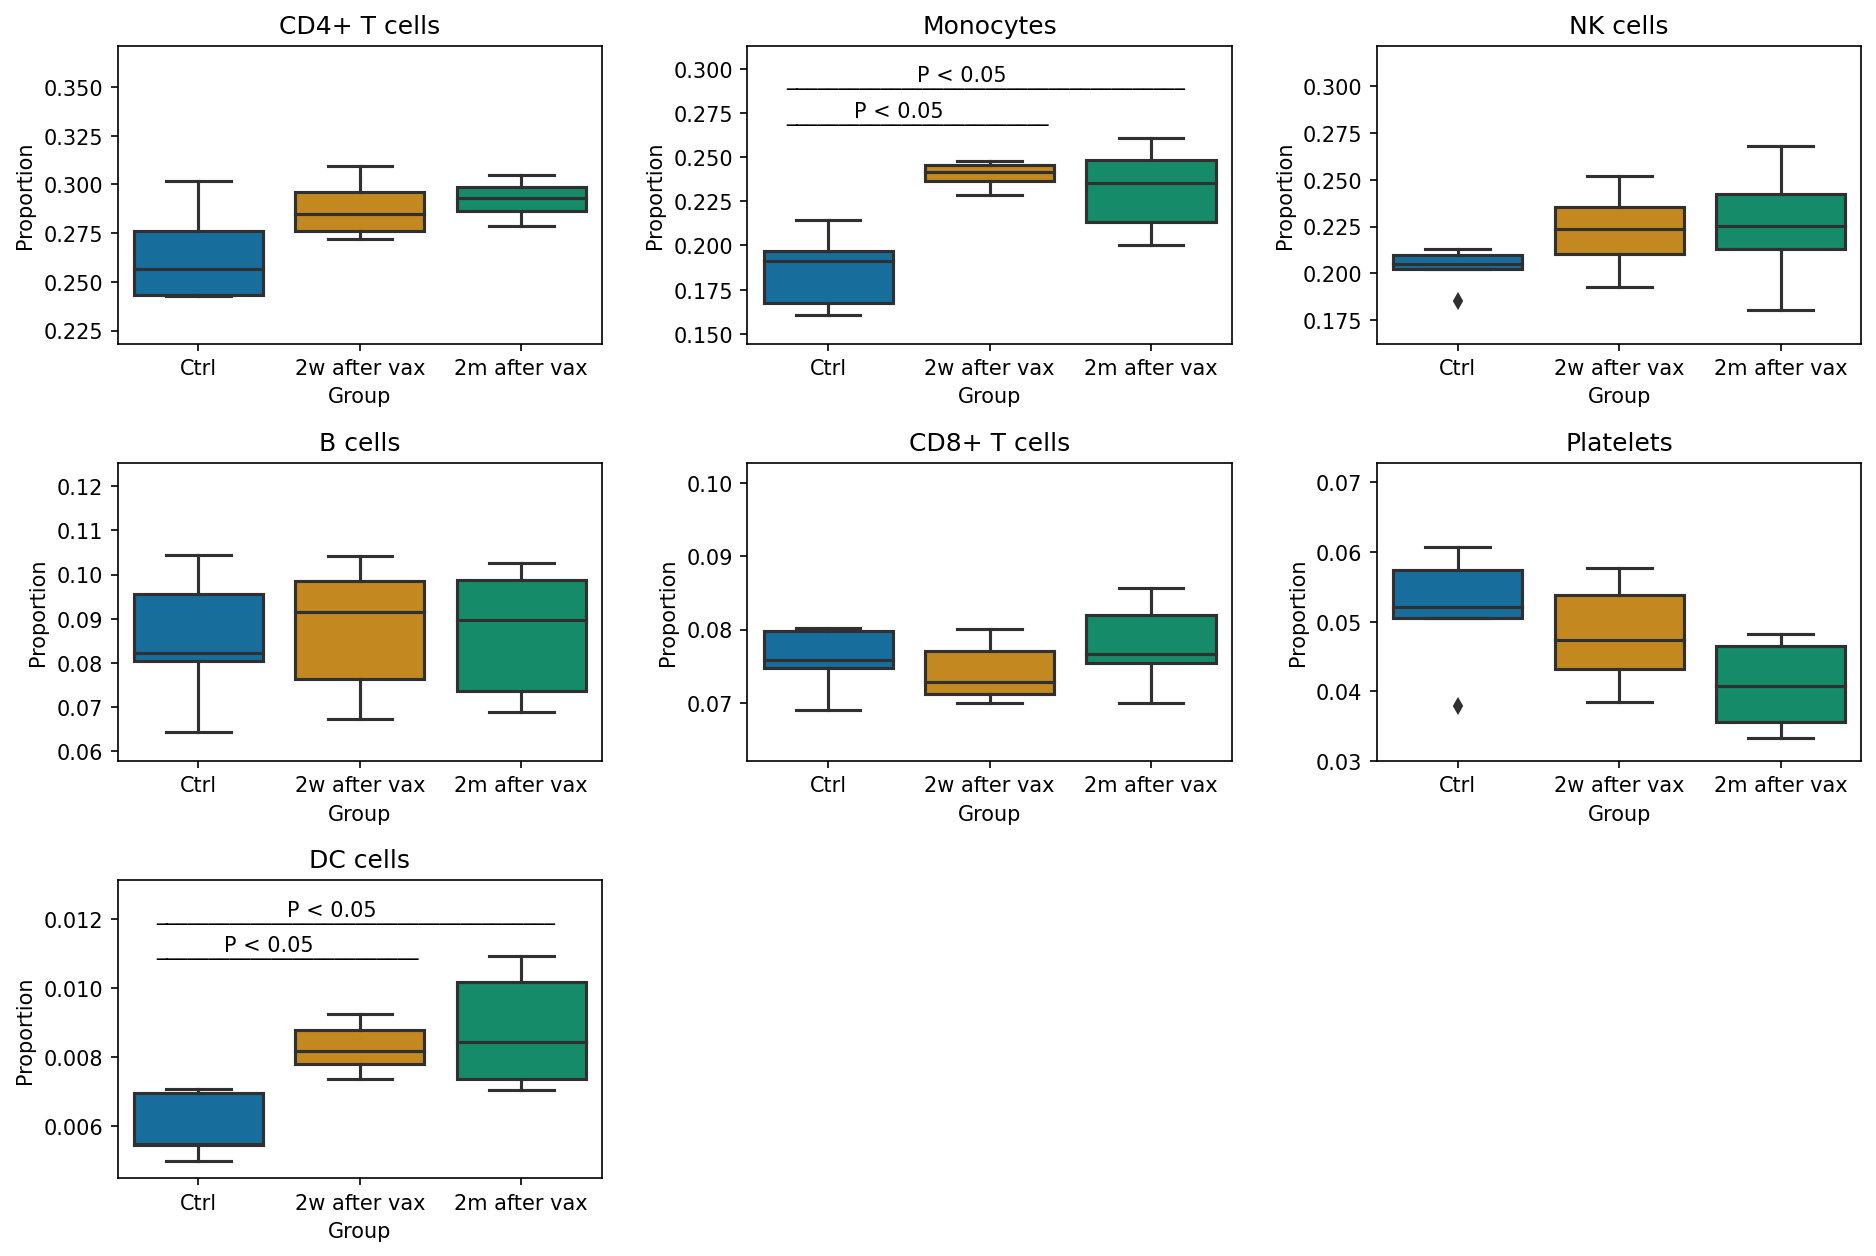

In [67]:
# Visualize with box plots
plt.figure(figsize=(15,10), dpi=150)
plt.figure(1)
loc = 331
for i in range(7):
    cluster = cluster_names[i]
    significance_tuple = proportion_significance_tuple_list[i]
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    ax = plt.subplot(loc)
    plt.title(cluster)
    ax = sns.boxplot(x='Group', y='Proportion',
                data=results[results['Cell type']==cluster], palette='colorblind')
    plt.ylim([min(results[results['Cell type']==cluster]['Proportion'])*0.9, 
             max(results[results['Cell type']==cluster]['Proportion'])*1.2])
    loc+=1
    if significance_tuple == (0,0):
        continue
    if significance_tuple == (1,1):
        plt.text(0.08,0.75,'_________________________', transform=ax.transAxes)
        plt.text(0.22,0.76,'P < 0.05', transform=ax.transAxes)
        plt.text(0.08,0.87,'______________________________________', transform=ax.transAxes)
        plt.text(0.35,0.88,'P < 0.05', transform=ax.transAxes)
    if significance_tuple == (0,1):
        plt.text(0.08,0.75,'______________________________________', transform=ax.transAxes)
        plt.text(0.35,0.76,'P < 0.05', transform=ax.transAxes)
    if significance_tuple == (1,0):
        plt.text(0.08,0.75,'_________________________', transform=ax.transAxes)
        plt.text(0.22,0.76,'P < 0.05', transform=ax.transAxes)